##Loading data from MySQL server

In [ ]:
!pip install pymysql
import pymysql
import pandas as pd

In [ ]:
#Define connection parameters
conn = pymysql.connect(
    host = "176.53.161.39",
    port = 3306,
    user = "medtracker",
    passwd = "gV74l7GbkhC3",
    db = "medtracker_data_saver"
)

In [ ]:
#Check connection
if conn != 0:
  print("Connection established.")
else:
  print("Connection NOT established.")

Connection established.


##Fetching records from the database for the latest month

In [ ]:
query_hr = "SELECT value, timestamp FROM heart_rate"

In [ ]:
query_temp = "SELECT value, timestamp FROM temperature"

##Convert records into Pandas dataframes

In [ ]:
dataframe_hr = pd.read_sql_query(query_hr, conn)
dataframe_temp = pd.read_sql_query(query_temp, conn)

##Preprocess data

Making sure there are no NULL values in the table

In [ ]:
dataframe_hr.shape
dataframe_hr.isnull().sum()

value        0
timestamp    0
dtype: int64

In [ ]:
dataframe_temp.shape
dataframe_temp.isnull().sum()

value        0
timestamp    0
dtype: int64

Making sure that the variables in the column 'value' are of numeric type

In [ ]:
dataframe_hr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41149 entries, 0 to 41148
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   value      41149 non-null  int64         
 1   timestamp  41149 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 643.1 KB


In [ ]:
dataframe_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68507 entries, 0 to 68506
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   value      68507 non-null  object        
 1   timestamp  68507 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 1.0+ MB


Since the items in the column 'value' of the temperature dataframe are of type 'object', they must be transformed to numeric type

In [ ]:
dataframe_temp.dropna(subset=['value'], axis = 0, inplace = True)
dataframe_temp['value'] = dataframe_temp['value'].astype(str).astype(float)

In [ ]:
dataframe_temp['value'].head(10)

0    27.95
1    27.96
2    27.96
3    27.95
4    27.97
5    27.95
6    27.94
7    27.95
8    27.94
9    27.91
Name: value, dtype: float64

Filter values lower than the normal standard (temperature data)

In [ ]:
mask_low = dataframe_temp.value < 33.0
column_name = 'value'
dataframe_temp.loc[mask_low, column_name] = 34.0
mask_high = dataframe_temp.value > 45.0
dataframe_temp.loc[mask_high, column_name]

Series([], Name: value, dtype: float64)

Since the preferred library is sklearn, the models will need something more concrete to work with: hour, day or year. Hence, the datetime format has to be broken down into individual components.For this, datetime library will give access to a specific aspect of the givem timestamp like year, day, hour...

In [ ]:
import datetime as dt
dataframe_temp['hour'] = dataframe_temp['timestamp'].dt.hour

The algorithm to be used is Logistic Regression, i.e. supervised learning. A class must be created where  determines high possibilities of the user being asleep and 0 determines high possibilities of the user being awake. (Based on the time of day, and temperature)

In [ ]:
import numpy as np

conditions_timestamp = [(dataframe_temp['hour'] >= 23) & (dataframe_temp['hour'] <= 7),
                        (dataframe_temp['hour'] >= 8) & (dataframe_temp['hour'] <= 22)]
choices_sleep = [1, 0]
dataframe_temp['binary_sleep'] = np.select(conditions_timestamp, choices_sleep, default=1)

In [ ]:
print(dataframe_temp)

       value           timestamp  hour  binary_sleep
0      34.00 2020-12-06 02:26:59     2             1
1      34.00 2020-12-06 02:27:00     2             1
2      34.00 2020-12-06 02:27:01     2             1
3      34.00 2020-12-06 02:27:02     2             1
4      34.00 2020-12-06 02:27:03     2             1
...      ...                 ...   ...           ...
68502  35.65 2020-12-26 19:58:15    19             0
68503  35.64 2020-12-26 19:58:16    19             0
68504  35.63 2020-12-26 19:58:17    19             0
68505  35.64 2020-12-26 19:58:18    19             0
68506  35.40 2020-12-26 19:58:19    19             0

[68507 rows x 4 columns]


##Classify data through Logistic Regression - beta machine learning model (on temperature data)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
lr = LogisticRegression(random_state=0) #initialize model

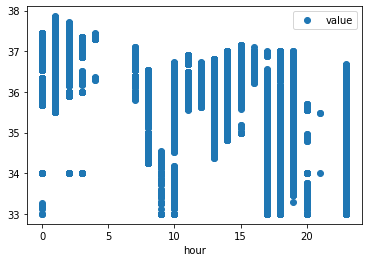

In [ ]:
dataframe_temp.plot(x='hour', y='value', style='o')

Creating Feature Arrays. X - data columns or features and Y - single dimensional array to output boolean predictions

In [ ]:
X_temp_features = dataframe_temp.iloc[:,-1:]
X_temp_features.tail()

,binary_sleep
68502,0
68503,0
68504,0
68505,0
68506,0


In [ ]:
Y_temp_output = dataframe_temp.iloc[:,0]
Y_temp_output = Y_temp_output.astype(int)
Y_temp_output.head()

0    34
1    34
2    34
3    34
4    34
Name: value, dtype: int64

Splitting the data into testing and training sets and fitting it into the model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_temp_features, Y_temp_output, test_size = 0.3, random_state = 31)

In [ ]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

##Accuracy Scores on Logistic Regression model (for Temperature data)

In [ ]:
y_pred = lr.predict(X_test)
accuracy = accuracy_score(X_test, y_pred)
print('Accuracy of logistic regression classifier on test set:{:.2f}'.format(lr.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set:0.43


Precision is the ratio between number of positives and number of false positives. 
The recall is the ratio between true positives and false negatives.
The F-beta score (f1) can be interpreted as a weighted harmonic mean of the precision and recall, where the best value is 1 and teh worst 0. 
The support is the number of occurrences of each class in y_test.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          33       0.00      0.00      0.00      1746
          34       0.00      0.00      0.00      3973
          35       0.00      0.00      0.00      3582
          36       0.43      1.00      0.60      8909
          37       0.00      0.00      0.00      2343

    accuracy                           0.43     20553
   macro avg       0.09      0.20      0.12     20553
weighted avg       0.19      0.43      0.26     20553



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
